In [1]:
import os
import cv2
import xml.etree.ElementTree as ET
import torch
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from glob import glob
from IPython.display import HTML, display
import matplotlib.patches as patches
from PIL import Image



# **Waste in Water Dataset - YOLO Format**

## **Dataset Format**
- Format: YOLOv5 (COCO-style)


## **Class Names**
0: Bottle cap
1: Can
2: Juice Box
3: Juice box
4: Metal
5: Metal Waste
6: Plastic
7: Plastic Bag
8: Plastic Bottle
9: Plastic Waste
10: Plastic bag
11: Plastic bottle
12: Plastic cup
13: Plastic packaging
14: Plastic-Bottle
15: Undefined trash
16: Wood
17: bottles
18: plastic

## **Description**
This dataset contains a total of 3798 images, with the split given below. It has images of multiple types of garbage that can be found in water bodies. The dataset has a total of 19 classes - though there is an overlap between them which needs to be resolved. However, since the scope of this project is to treat all trash equally - we have not made any changes to the dataset as of yet. We did train an initial model for 50 epochs using this dataset and found it to be passable for now - but real experiments are needed to judge actual usablity. This dataset was downloaded from https://universe.roboflow.com/chinatele/waste-in-water/dataset/1


In [2]:
class YoloDataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size=640):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.img_files = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        label_path = os.path.join(self.label_dir, self.img_files[idx].replace('.jpg', '.txt').replace('.png', '.txt').replace('.webp', '.txt'))

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.img_size, self.img_size))

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                boxes = [list(map(float, line.strip().split())) for line in f.readlines()]
        else:
            boxes = []

        return image, boxes


In [3]:
root_dir = "WaterDataset" 
train_dataset = YoloDataset(
    img_dir=os.path.join(root_dir, "train/images"),
    label_dir=os.path.join(root_dir, "train/labels")
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)


In [4]:
import yaml

yaml_path = "WaterDataset/data.yaml"
base_dir = os.path.dirname(yaml_path)


with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

# Extract class names
class_names = data.get('names', [])
print(f"{len(class_names)} classes:")
for idx, name in enumerate(class_names):
    print(f"{idx}: {name}")

base_dir = "WaterDataset"
splits = {
    "Train": os.path.join(base_dir, "train", "images"),
    "Val": os.path.join(base_dir, "valid", "images"),
    "Test": os.path.join(base_dir, "test", "images")
}

split_sizes = {}
for split, path in splits.items():
    images = []
    for ext in ('*.jpg', '*.jpeg', '*.png', '*.webp'):
        images.extend(glob(os.path.join(path, ext)))
    split_sizes[split] = len(images)

print("Dataset Split Sizes:")
for split, count in split_sizes.items():
    print(f"  {split}: {count} images")

print(f"    Total images: {sum(split_sizes.values())}")

19 classes:
0: Bottle cap
1: Can
2: Juice Box
3: Juice box
4: Metal
5: Metal Waste
6: Plastic
7: Plastic Bag
8: Plastic Bottle
9: Plastic Waste
10: Plastic bag
11: Plastic bottle
12: Plastic cup
13: Plastic packaging
14: Plastic-Bottle
15: Undefined trash
16: Wood
17: bottles
18: plastic
Dataset Split Sizes:
  Train: 3575 images
  Val: 157 images
  Test: 66 images
    Total images: 3798


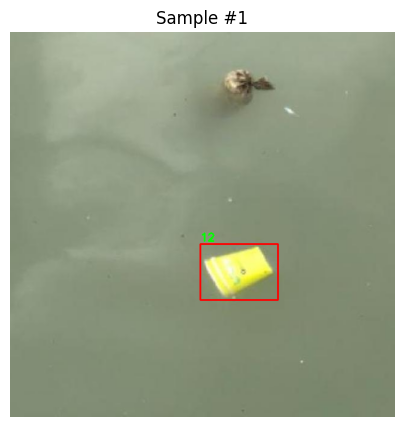

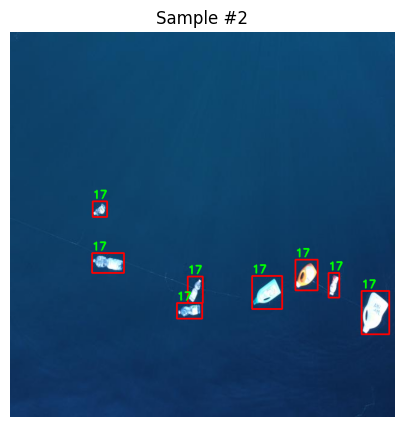

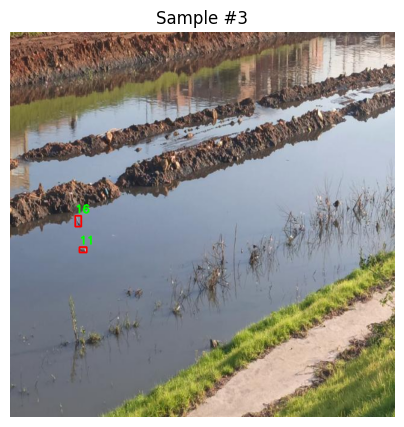

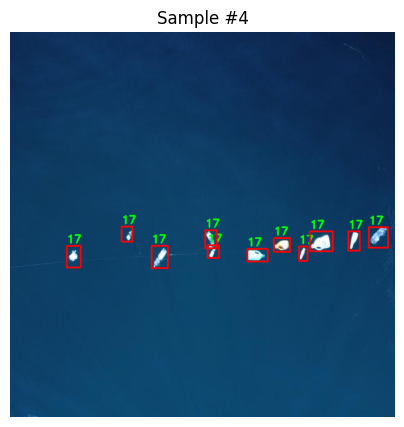

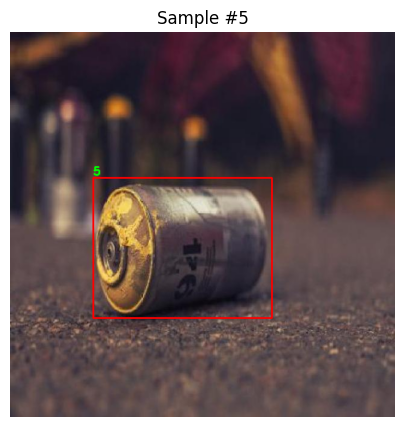

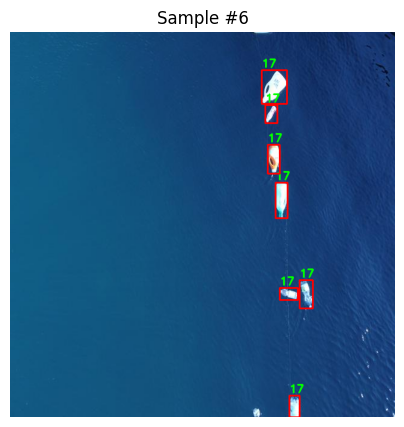

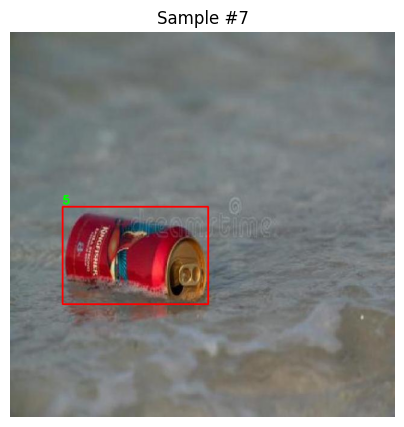

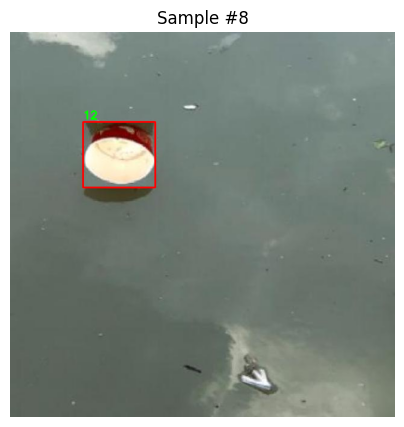

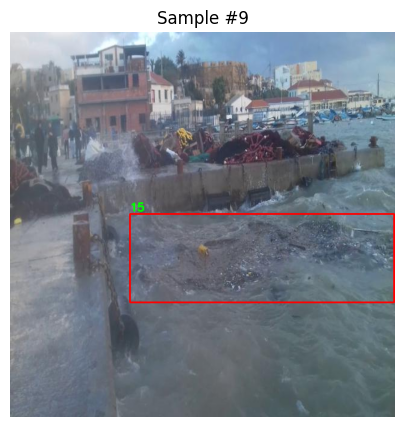

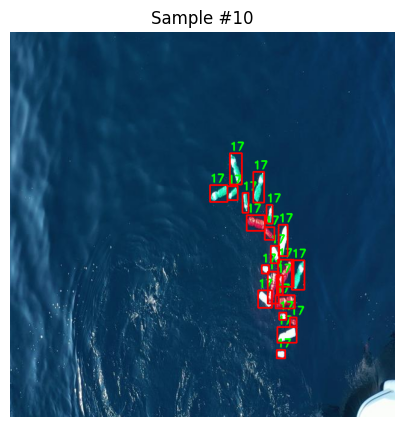

In [5]:
def plot_sample(image, boxes):
    h, w, _ = image.shape
    for box in boxes:
        cls, cx, cy, bw, bh = box
        x1 = int((cx - bw/2) * w)
        y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w)
        y2 = int((cy + bh/2) * h)
        cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2)
        cv2.putText(image, str(int(cls)), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    return image

for i in range(10):
    img, boxes = train_dataset[random.randint(0, len(train_dataset)-1)]
    plt.figure(figsize=(5, 5))
    plt.imshow(plot_sample(img.copy(), boxes))
    plt.axis('off')
    plt.title(f"Sample #{i+1}")
    plt.show()


# **FloW_IMG Dataset - VOC Format**

## **Dataset Format**
- Format: Pascal VOC

## **Class Names**
- [x] Class 0: `bottle`

## **Description**
This dataset contains 1200 images of plastic bottles floating in water. 800 of these images are from the train set and the remaining 400 are for testing. We tried training a model on this dataset first but the results were subpar since the images were not of great quality. More work and augmentation will be needed for this dataset if we intend to use it later on. However, it also contains 250 videos of a small boat in a river which can be extremely useful for testing until we can test the actual boat ourselves. We got this dataset with permission from Orca Tech.

In [6]:
class VOCDataset(Dataset):
    def __init__(self, image_dir, annot_dir, transform=None):
        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
        self.transform = transform
        self.class_names = self._extract_class_names()
        self.class_to_idx = {name: idx for idx, name in enumerate(sorted(self.class_names))}

    def _extract_class_names(self):
        classes = set()
        for annot_file in os.listdir(self.annot_dir):
            tree = ET.parse(os.path.join(self.annot_dir, annot_file))
            root = tree.getroot()
            for obj in root.findall("object"):
                classes.add(obj.find("name").text)
        return list(classes)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_file)
        annot_path = os.path.join(self.annot_dir, os.path.splitext(img_file)[0] + ".xml")

        image = Image.open(img_path).convert("RGB")
        boxes = []
        labels = []

        tree = ET.parse(annot_path)
        root = tree.getroot()
        for obj in root.findall("object"):
            name = obj.find("name").text
            label = self.class_to_idx[name]
            bndbox = obj.find("bndbox")
            box = [
                int(bndbox.find("xmin").text),
                int(bndbox.find("ymin").text),
                int(bndbox.find("xmax").text),
                int(bndbox.find("ymax").text),
            ]
            boxes.append(box)
            labels.append(label)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {"boxes": boxes, "labels": labels}
        return image, target

In [7]:
transform = T.ToTensor()

voc_dataset = VOCDataset(
    image_dir="FloW_IMG/training/images",
    annot_dir="FloW_IMG/training/annotations",
    transform=transform
)

print(f"Number of samples: {len(voc_dataset)}")
print(f"Number of classes: {len(voc_dataset.class_names)}")
print("Classes:")
for i, name in enumerate(voc_dataset.class_names):
    print(f"{i}: {name}")


Number of samples: 1200
Number of classes: 1
Classes:
0: bottle


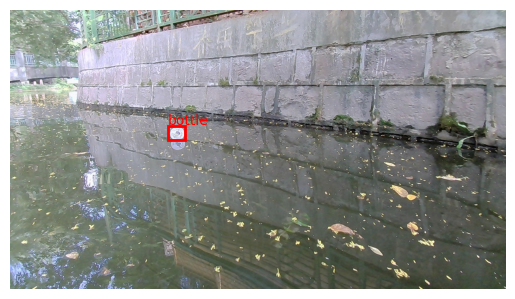

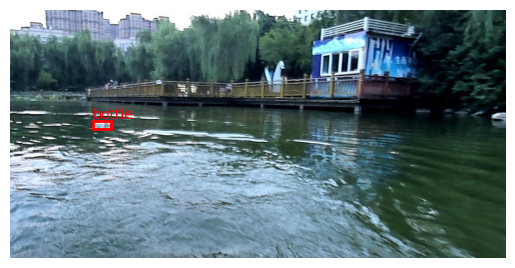

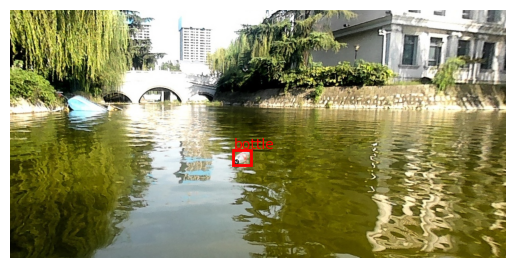

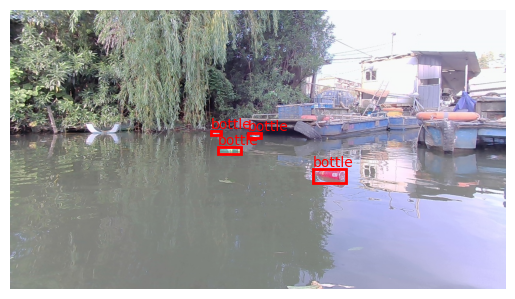

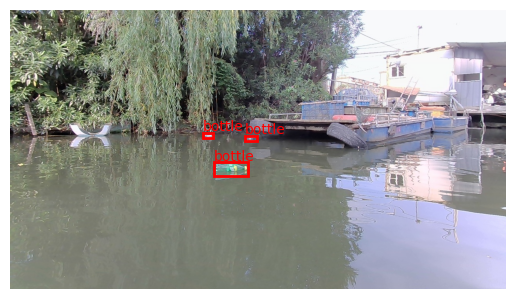

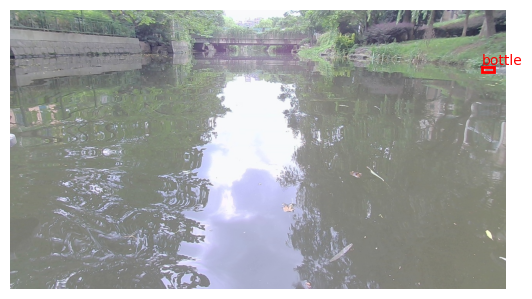

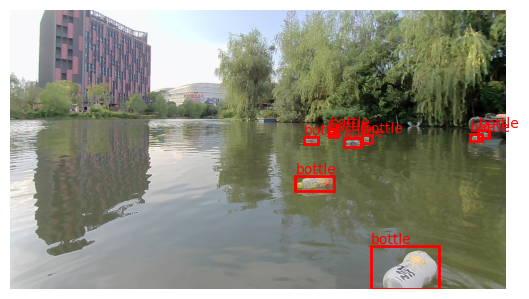

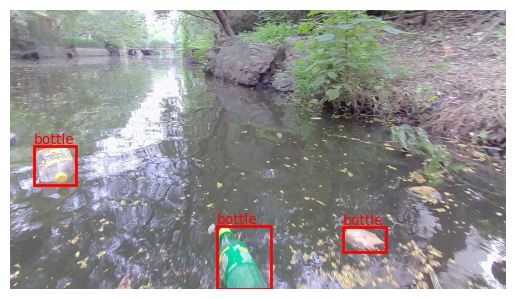

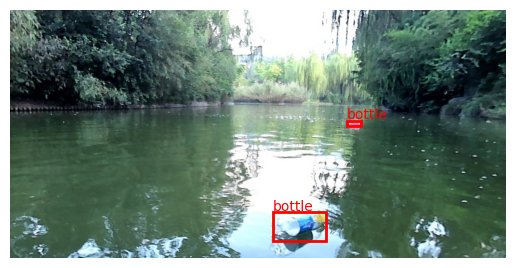

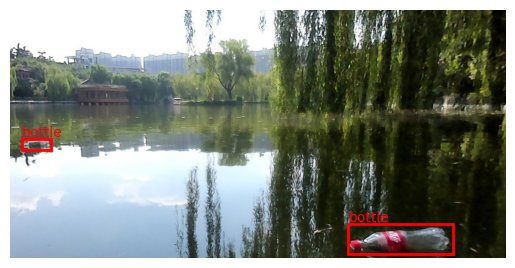

In [8]:
def show_samples(dataset, num_samples=10):
    for i in range(num_samples):
        image, target = dataset[i]
        image_np = image.permute(1, 2, 0).numpy()
        fig, ax = plt.subplots(1)
        ax.imshow(image_np)

        for box, label in zip(target["boxes"], target["labels"]):
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, dataset.class_names[label], color='red', fontsize=10)
        plt.axis("off")
        plt.show()

show_samples(voc_dataset)
